# Example 1: Cepstral Analysis of liquid water

This example shows the basic usage of *sportran* to compute the shear viscosity of a classical MD simulation of H$_2$O.

For reference: <a href="https://doi.org/10.1038/s41524-022-00830-7">Malosso et al., npj Comput Mater 8, 139 (2022).</a>


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
try:
    import sportran as st
except ImportError:
    from sys import path
    path.append('..')
    import sportran as st

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

from numba import njit,jit
from scipy.integrate import cumtrapz

## 1. Load trajectory

Read the heat current from a simple column-formatted file $\texttt{./data/h2o/h2o.dat}$.

In [2]:
!head -n 1 data/h2o/h2o.dat

Temp	s_xy	s_xz	s_yz 


In [3]:
jfile = st.i_o.TableFile('./data/h2o/h2o.dat')
jfile.read_datalines()

Temp	s_xy	s_xz	s_yz 
 #####################################
  all_ckeys =  [('Temp', [0]), ('s_xy', [1]), ('s_xz', [2]), ('s_yz', [3])]
 #####################################
Data length =  100000
  ckey =  [('Temp', [0]), ('s_xy', [1]), ('s_xz', [2]), ('s_yz', [3])]
    step =    100000 - 100.00% completed
  ( 100000 ) steps read.
DONE.  Elapsed time:  1.4065170288085938 seconds


{'Temp': array([[408.14857],
        [404.83967],
        [400.74475],
        ...,
        [375.49635],
        [374.86153],
        [373.89371]]),
 's_xy': array([[788.37874],
        [636.10743],
        [478.48531],
        ...,
        [501.14159],
        [552.52985],
        [564.72988]]),
 's_xz': array([[  14.137608],
        [ -89.647884],
        [-201.87593 ],
        ...,
        [-251.91173 ],
        [-302.26323 ],
        [-333.25187 ]]),
 's_yz': array([[-171.66794],
        [-178.72951],
        [-164.36904],
        ...,
        [ 633.03153],
        [ 419.70789],
        [ 191.02963]])}

## 2. Stress Current

Define a **StressCurrent** from the trajectory, with the correct parameters. For the computation of the shear viscosity we need only the off diagonal elements of the stress tensor that are stored in **data[:,1:]** and the instantanous temperatures that are stored in **data[ : ,0]**.

In [4]:
DT_FS = 1                                  # time step [fs]
TEMPERATURE = np.mean(jfile.data['Temp'])  # temperature [K] (983.173 K)
VOLUME = 1918.4149658                      # volume [A^3]
print(DT_FS, TEMPERATURE, VOLUME)

j = st.StressCurrent(np.column_stack([jfile.data['s_xy'], jfile.data['s_xz'], jfile.data['s_yz']]),
                     UNITS='real', DT_FS=DT_FS, TEMPERATURE=TEMPERATURE, VOLUME=VOLUME)

1 398.46784250010006 1918.4149658
Using single component code.


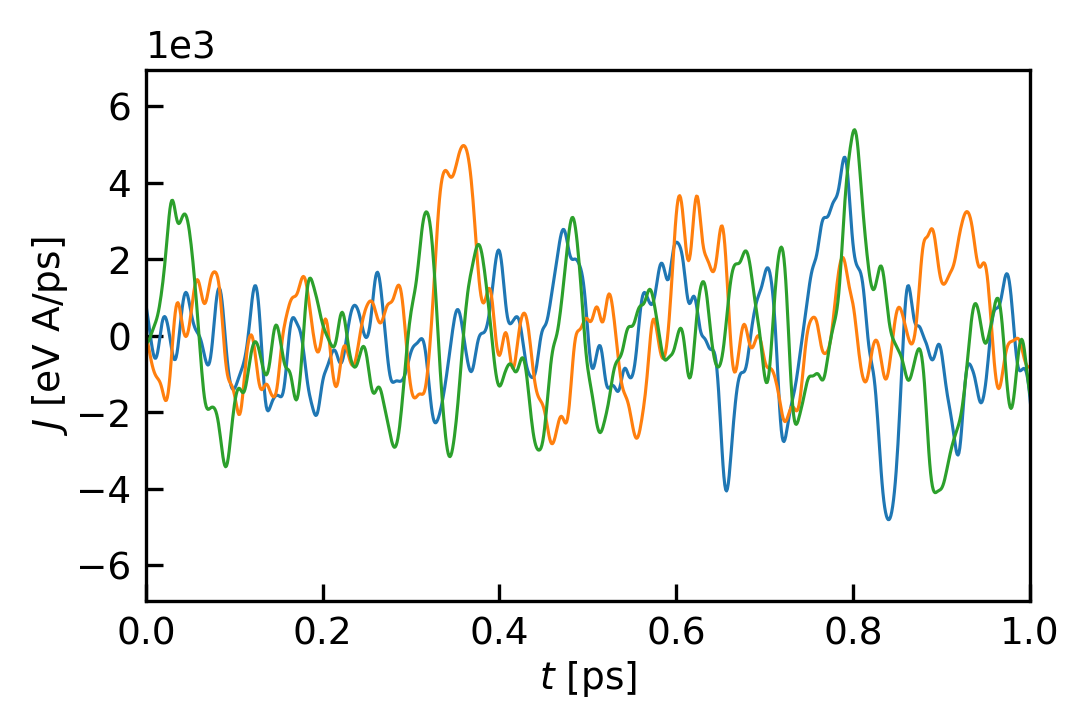

In [5]:
# trajectory
f = plt.figure()
ax = plt.plot(j.timeseries()/1000., j.traj);
plt.xlim([0, 1.0])
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$J$ [eV A/ps]');

Compute the **Power Spectral Density** ($\rm PSD$) and filter it for visualization.

500.0


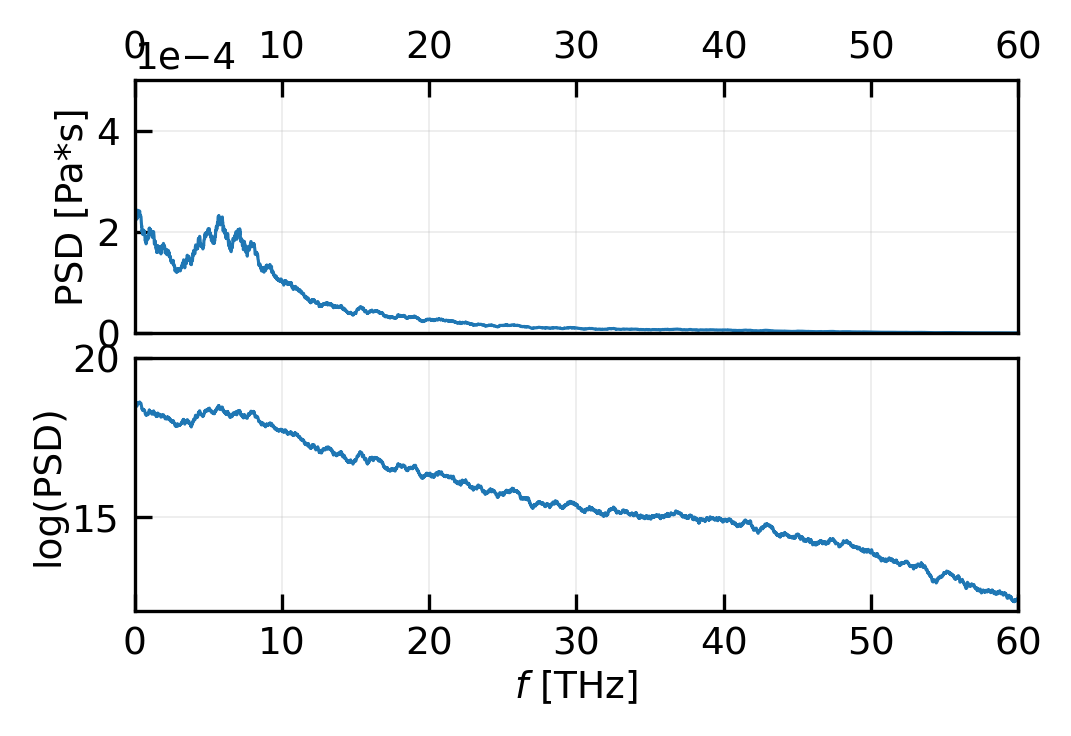

In [6]:
# Periodogram with given filtering window width
ax = j.plot_periodogram(PSD_FILTER_W=0.5, kappa_units=True)
print(j.Nyquist_f_THz)
plt.xlim([0, 60])
ax[0].set_ylim([0, 0.5e-3]);
ax[1].set_ylim([12, 20]);

## 3. Resampling

If the Nyquist frequency is very high (*i.e.* the sampling time is very small), such that the log-spectrum goes to low values, you may want *resample* your time series, in order to reduce the maximum frequency to $f^*$.
Before performing that operation, the time series is automatically filtered to reduce the amount of aliasing introduced. Ideally you do not want to go too low in $f^*$, because the statistical error may increase. In an intermediate region the results should not change. 

To perform resampling you can choose the resampling frequency $f^*$ (`fstar_THz`) or the resampling step (`TSKIP`). If you choose $f^*$, the code will try to find the closest value allowed.
The resulting $\rm PSD$ can be visualized to ensure that the low-frequency region was not affected by this operations

Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      25.00000 THz
 Sampling time         TSKIP =            20 steps
                             =        20.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2501
 PSD      @cutoff  (pre-filter&sample) ~ 8472561.64839
                  (post-filter&sample) ~ 7406104.37649
 log(PSD) @cutoff  (pre-filter&sample) ~     15.68271
                  (post-filter&sample) ~     15.63555
 min(PSD)          (pre-filter&sample) =      0.07246
 min(PSD)         (post-filter&sample) = 299500.00551
 % of original PSD Power f<f* (pre-filter&sample)  = 92.375 %
-----------------------------------------------------



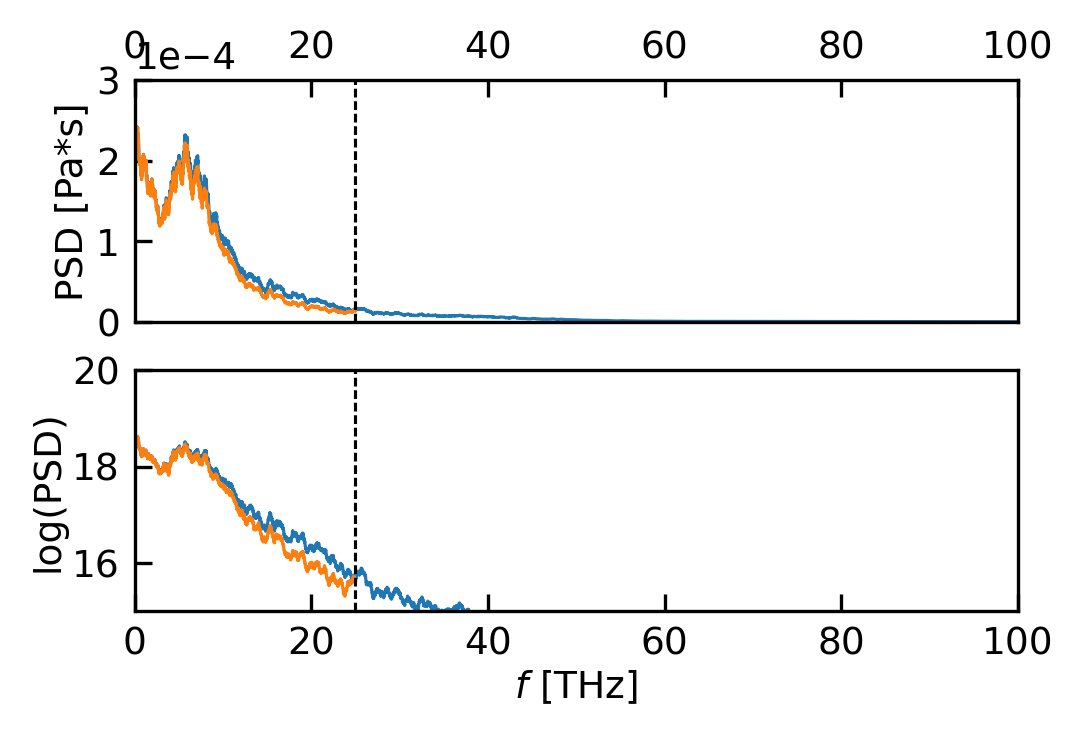

In [7]:
FSTAR_THZ = 25
jf, ax = j.resample(fstar_THz=FSTAR_THZ, plot=True, freq_units='thz')
plt.xlim([0, 100])
ax[0].set_ylim([0, 0.3e-3]);
ax[1].set_ylim([15, 20]);

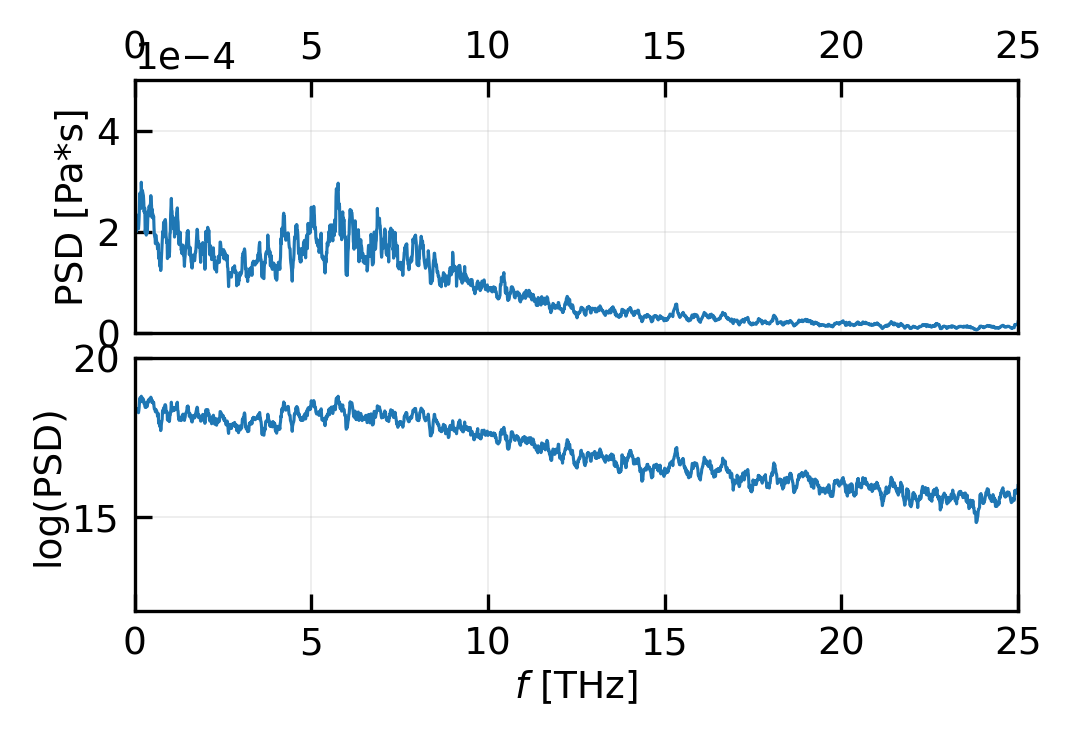

In [8]:
ax = jf.plot_periodogram(PSD_FILTER_W=0.1)
ax[0].set_ylim([0, 0.5e-3]);
ax[1].set_ylim([12, 20]);

## 4. Cepstral Analysis

Perform Cepstral Analysis. The code will perform the following operations:
 1. compute the parameters describing the theoretical distribution of the $\rm PSD$
 2. compute the Cepstral coefficients by Fourier transforming the $\log(\rm{PSD})$
 3. apply the Akaike Information Criterion, to choose the number of cepstral coefficients $P^*$
 4. return the resulting transport coefficient (viscosity) $\eta$

In [9]:
jf.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 10  (auto, AIC_Kmin = 10, corr_factor =  1.0)
  L_0*   =          18.297017 +/-   0.057597
  S_0*   =   127801909.034037 +/- 7361041.782368
-----------------------------------------------------
  kappa* =           0.000229 +/-   0.000013  Pa*s
-----------------------------------------------------



c_k =  [ 1.72206042e+01  6.94703788e-01 -4.33846235e-02 ...  2.22448841e-03
  1.09731963e-03  7.87480033e-03]


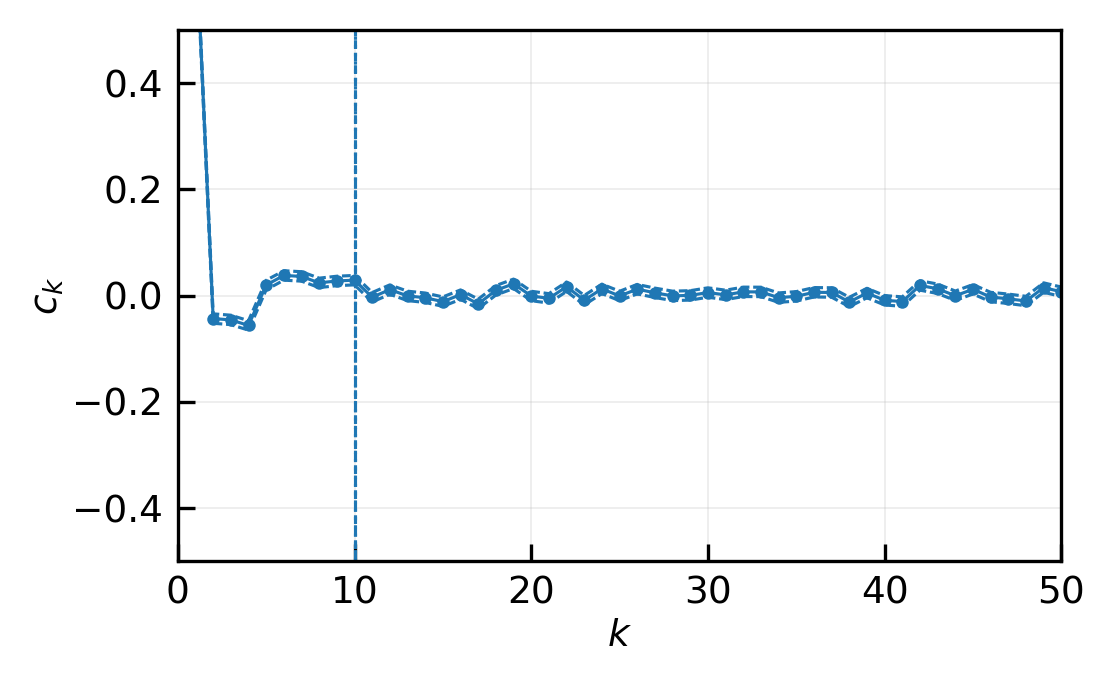

In [10]:
# Cepstral Coefficients
print('c_k = ', jf.cepf.logpsdK)

ax = jf.plot_ck()
ax.set_xlim([0, 50])
ax.set_ylim([-0.5, 0.5])
ax.grid();

K of AIC_min = 10
AIC_min = 2540.981427


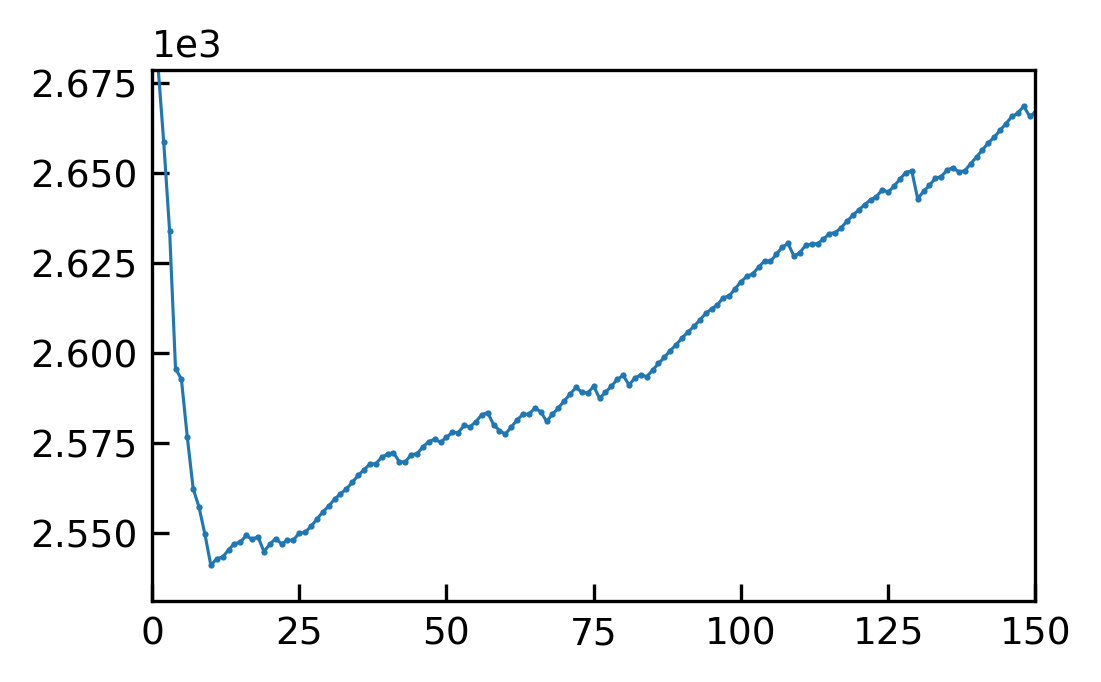

In [11]:
# AIC function
f = plt.figure()
plt.plot(jf.cepf.aic, '.-', c=c[0])
plt.xlim([0, 150])
plt.ylim([min(jf.cepf.aic[:150]) - 10, max(jf.cepf.aic[50:150]) + 10]);

print('K of AIC_min = {:d}'.format(jf.cepf.aic_Kmin))
print('AIC_min = {:f}'.format(jf.cepf.aic_min))

Plot the viscosity $\eta$ as a function of the cutoff $P^*$

K of AIC_min = 10
AIC_min = 2540.981427


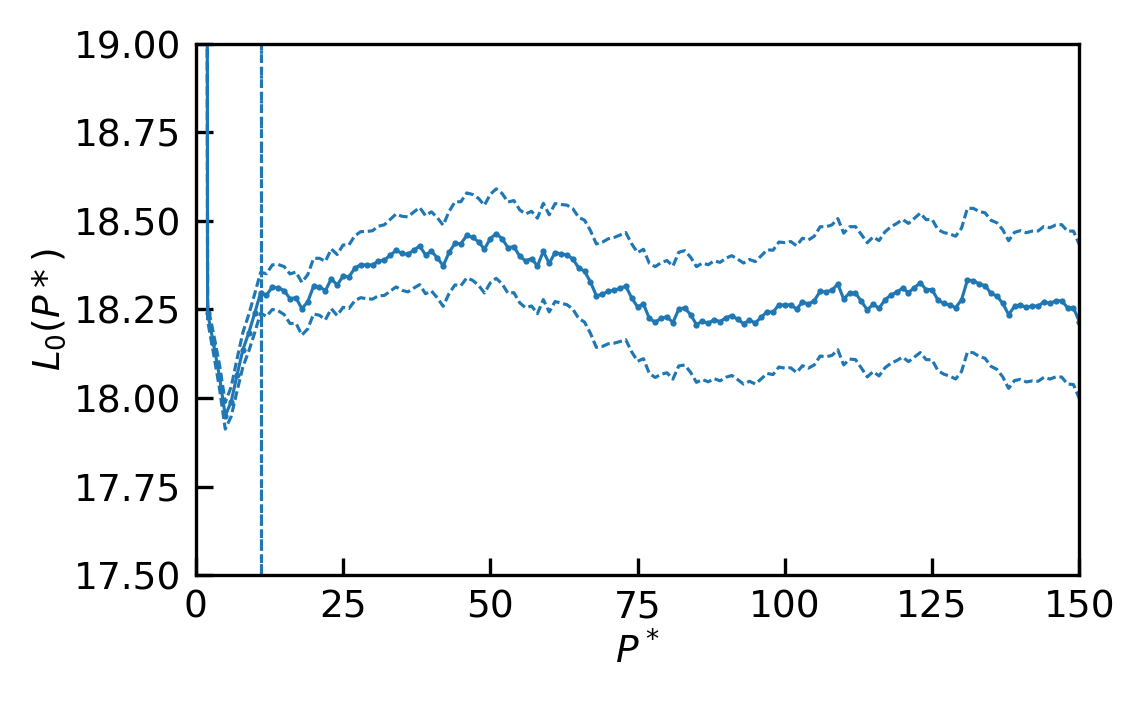

In [12]:
# L_0 as a function of cutoff K
ax = jf.plot_L0_Pstar()
ax.set_xlim([0, 150])
ax.set_ylim([17.5, 19]);

print('K of AIC_min = {:d}'.format(jf.cepf.aic_Kmin))
print('AIC_min = {:f}'.format(jf.cepf.aic_min))

K of AIC_min = 10
AIC_min = 2540.981427


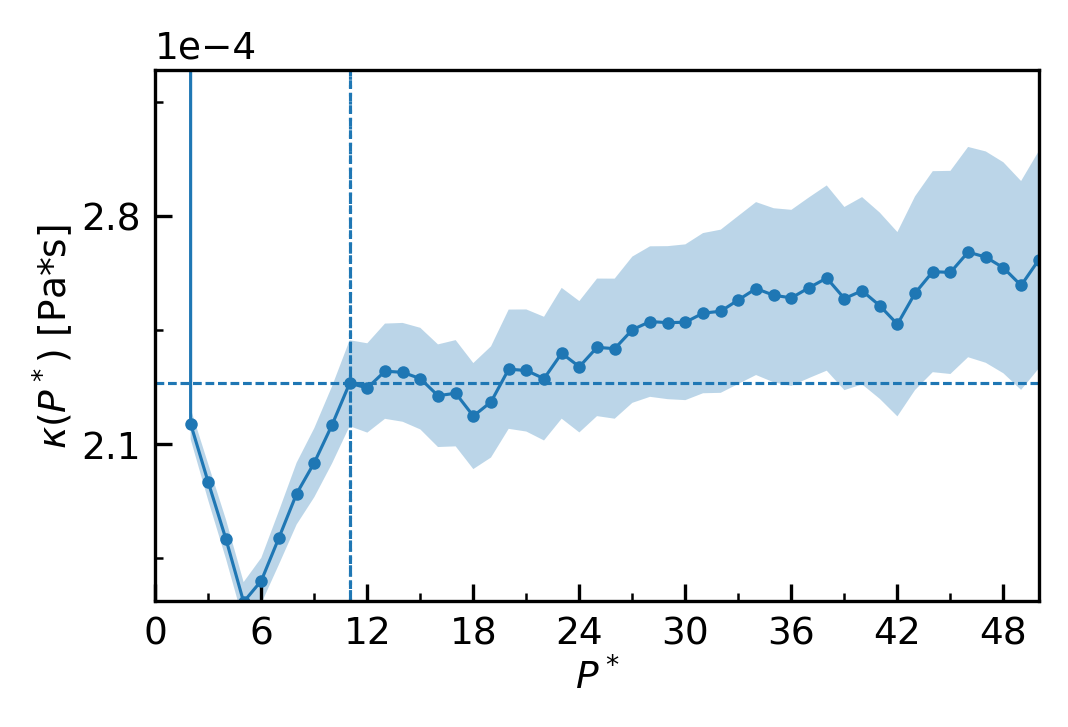

In [13]:
# kappa as a function of cutoff K
ax = jf.plot_kappa_Pstar()
ax.set_xlim([0, 50])
#ax.set_ylim([0, 5.0]);

print('K of AIC_min = {:d}'.format(jf.cepf.aic_Kmin))
print('AIC_min = {:f}'.format(jf.cepf.aic_min))

Print the results :)

In [14]:
results = jf.cepstral_log
print(results)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 10  (auto, AIC_Kmin = 10, corr_factor =  1.0)
  L_0*   =          18.297017 +/-   0.057597
  S_0*   =   127801909.034037 +/- 7361041.782368
-----------------------------------------------------
  kappa* =           0.000229 +/-   0.000013  Pa*s
-----------------------------------------------------



You can now visualize the filtered PSD...

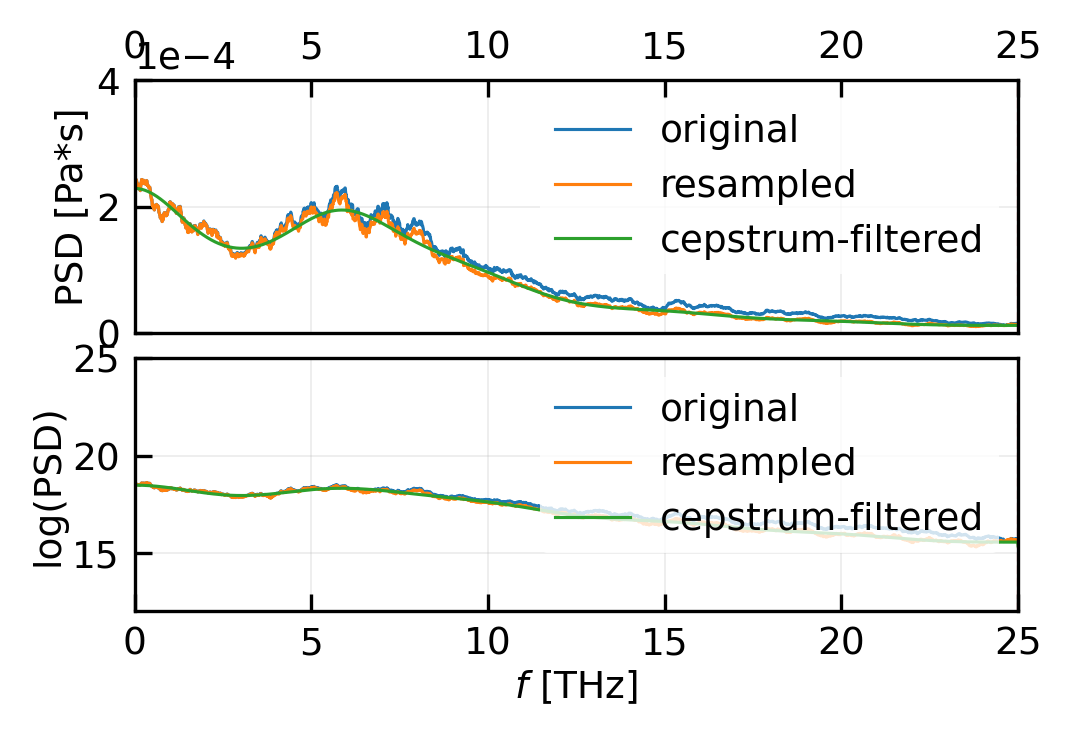

In [15]:
# filtered log-PSD
ax = j.plot_periodogram(0.5, kappa_units=True)
ax = jf.plot_periodogram(0.5, axes=ax, kappa_units=True)
ax = jf.plot_cepstral_spectrum(axes=ax, kappa_units=True)
ax[0].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
ax[1].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 25.])
ax[0].set_ylim([0,4e-4])
ax[1].set_ylim([12,25])
ax[0].legend(['original', 'resampled', 'cepstrum-filtered'])
ax[1].legend(['original', 'resampled', 'cepstrum-filtered']);

# Direct Green-Kubo integration

We compute the ACF. To have more statistics and better define an uncertainty, we split the total time-series in **two** segments of three Cartesian components each (i.e., $x$, $y$ and $z$).

The GK formula is
$$
\eta(\tau) = \frac{V}{k_B T } \int_0^\tau \mathrm{ACF}(t)\, dt
$$

or, equivalently, the Helfand-Einstein formula (displaying better convergence, see Appendix A of https://doi.org/10.1140/epjb/s10051-021-00152-5)

$$
\eta(\tau) = \frac{V}{k_B T } \int_0^\tau \left(1 - \frac{t}{\tau}\right)\, \mathrm{ACF}(t)\, dt
$$
where
$$
\mathrm{ACF}(t) = \frac{1}{\ell} \sum_{a=1}^{\ell} \left< \sigma_a(t) \sigma_a(0) \right>
$$
being $\ell$ the number of independent samples (here 3 off-diagonal components $\times$ 2 segments, i.e. $\ell=6$. $a$ labels $xy$, $xz$, or $yz$).

Below we use `numpy` or `scipy` functions in a way we do not need to manually insert $\ell=6$. 

In [20]:
@jit(nopython = True)
def ACF(a,tcor,trun,tgap=10):
    
    """
    Computes the auto-correlation function.
    Cf. Allen-Tildesley, 1989, p.186
    """

    acf  = np.zeros(tcor+1)
    norm = np.zeros(tcor+1)
    
    for t0 in range(1,trun+1,tgap):
        a0 = a[t0]
        tt0max = min(trun, t0 + tcor)
        for tt0 in range(t0,tt0max+1):
            t       = tt0 - t0
            acf[t]  = acf[t] + a0 * a[tt0]
            norm[t] = norm[t] + 1.0
            
    for t in range(tcor+1):
        acf[t] = acf[t] / norm[t]
        
    return acf,norm

In [21]:
kB_SI = 1.38e-23                           # Boltzmann's constant
ang3_SI = 1e-30                            # cubic metres
fs_s = 1e-15                               # fs in seconds
atm = 1.013e5                              # atmosphere in Pascals

segments = 2    
tgap = 10    # see Allen-Tildelsey's book for better understanding
tcor = 10000  # maximum value of time (in timesteps) at which we want to compute the ACF 
acf_ = []
data = np.column_stack([jfile.data['s_xy'], jfile.data['s_xz'], jfile.data['s_yz']])
n = len(data[:,1])//segments
print(n)
for i in range(segments):
    tmp , norm = ACF(data[(i*n):(i*n+n),0],tcor,n-tcor,tgap=tgap)
    acf_.append(tmp)
    tmp , norm = ACF(data[(i*n):(i*n+n),1],tcor,n-tcor,tgap=tgap)
    acf_.append(tmp)
    tmp , norm = ACF(data[(i*n):(i*n+n),2],tcor,n-tcor,tgap=tgap)
    acf_.append(tmp)
    

acf = np.column_stack(acf_)


conv =  VOLUME*ang3_SI * DT_FS*fs_s / (TEMPERATURE*kB_SI ) * atm**2 # prefactor and convers. units to SI
# the DT_FS is the dt of integration, see line below

intgr    = cumtrapz(acf,axis=0)*conv    # integral function eta(t)

D_intgr_HE = cumtrapz(acf * np.arange(acf.shape[0])[:,None],axis=0)*conv   
upper_T    = 1.0 + np.arange(D_intgr_HE.shape[0])  # upper extremum of integration 
intgr_HE   = intgr - D_intgr_HE / upper_T[:,None]  # Helfand-Einstein integral formula for eta(t) 

x = np.arange(len(intgr))*DT_FS*1e-3    # t array in picoseconds

50000


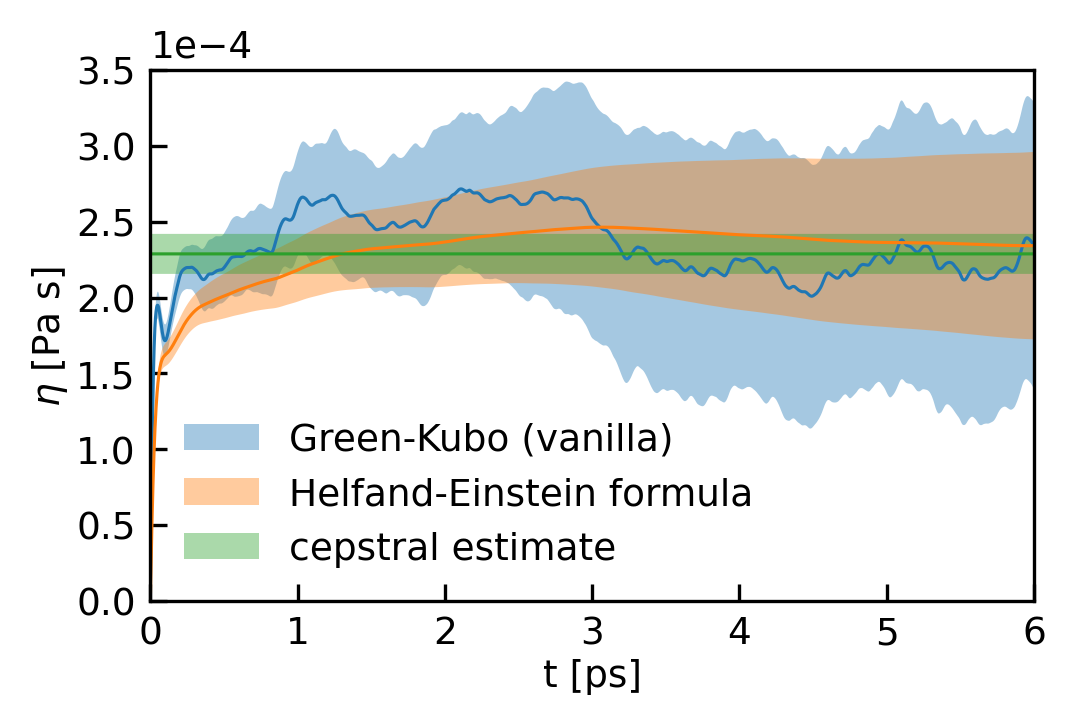

In [22]:
f = plt.figure()

y = np.mean(intgr,axis=1)
yerr = np.std(intgr,axis=1,ddof=1)/np.sqrt(intgr.shape[1]) # error on the mean
plt.plot(x,y)
plt.fill_between(x,y+yerr,y-yerr,alpha= 0.4,label='Green-Kubo (vanilla)')


y = np.mean(intgr_HE,axis=1)
yerr = np.std(intgr_HE,axis=1,ddof=1)/np.sqrt(intgr_HE.shape[1]) # error on the mean
plt.plot(x,y)
plt.fill_between(x,y+yerr,y-yerr,alpha= 0.4,label='Helfand-Einstein formula')


y = np.ones(len(x))*jf.kappa  # value from cepstral analysis
yerr = np.ones(len(x))*jf.kappa_std  # error from cepstral analysis

plt.xlabel('t [ps]')
plt.ylabel(r'$\eta$ [Pa s]')
plt.plot(x,y)
plt.fill_between(x,y+yerr,y-yerr,alpha= 0.4,label='cepstral estimate')
plt.xlim(0,6)
plt.ylim(0,3.5e-4)
plt.legend()
plt.show()